In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [3]:
!mkdir drive
!google-drive-ocamlfuse drive

In [4]:
import os 
os.chdir("/content/drive")

In [5]:
import os 
os.chdir("/content/drive/Colab_Notebooks/2december")
!pwd

/content/drive/Colab_Notebooks/2december


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from keras import backend as K


In [7]:
dtrain = pd.read_csv('train.csv')
dtrain.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [8]:

# we need to convert features to meanings(numbers, characters etc.) that can be used for deep learning 
def preprocess(data):
    
    #convert cabin info to number 
    data.Cabin.fillna('0', inplace=True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
    
    # convert gender info to number
    data['Sex'].replace('female', 1, inplace=True)
    data['Sex'].replace('male', 2, inplace=True)
    
    # convert port info to number 
    data['Embarked'].replace('S', 1, inplace=True)
    data['Embarked'].replace('C', 2, inplace=True)
    data['Embarked'].replace('Q', 3, inplace=True)
    
    # if some cell is empty, we need to fill this cell with median values.
    # median values provides balance not to destroy (fill not available - .fillna)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].median(), inplace=True)
    
    # when we want to ignore empty cell: (use .dropna)
    # drop not available -- data.dropna
    # data.dropna(subset=['Fare', 'Embarked'], inplace=True, how='any')

    return data 
   

In [9]:
def group_titles(data):

    #train data includes passengers' title and it includes social status information.
    #involving titles into training process can be important, titles 
    

    #extract title info from name columns (using ReGex)
    data['Names'] = data['Name'].map(lambda x: len(re.split(' ', x)))
    data['Title'] = data['Name'].map(lambda x: re.search(', (.+?) ', x).group(1))
    data['Title'].replace('Master.', 0, inplace=True)
    data['Title'].replace('Mr.', 1, inplace=True)
    data['Title'].replace(['Ms.','Mlle.', 'Miss.'], 2, inplace=True)
    data['Title'].replace(['Mme.', 'Mrs.'], 3, inplace=True)
    data['Title'].replace(['Dona.', 'Lady.', 'the Countess.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'the'], 4, inplace=True)

In [10]:
def data_subset(data):
    #define features
    #model will be trained according to the feautures.

    features = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Names', 'Title', 'Age', 'Cabin'] #, 'Fare', 'Embarked']
    lengh_features = len(features)
    subset = data[features]
    return subset, lengh_features

In [26]:
def create_model(train_set_size, input_length, num_epochs, batch_size):
    #neural network infrastructure is prepared here
    

    #model has 3 layers
    #input = features
    #activation: softplus

    model = Sequential()
    #layers: 7,3 and 1 neurons
    model.add(Dense(7, input_dim=input_length, activation='softplus'))
    model.add(Dense(3, activation='softplus'))
    model.add(Dense(1, activation='softplus'))

    lr = .001 #learning rate is set as 0,001
    adam0 = Adam(lr = lr) # optimizer: adam(learning rate = 0.001)

    #train model compile part: 
    #our model is focused 'accuracy' and 'loss' as metrics. 
    #loss function is set as binary cross entropy 
    model.compile(loss='binary_crossentropy', optimizer=adam0, metrics=['accuracy'])
    filepath = 'weights.best.hdf5'  
    checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max') #if max, save_best_only= true
    callbacks_list = [checkpoint] #callback used for saving best results in accuracy while compiling
    

    #model training process
    #x_train: function input , y_train: function output, callback= weights, epoch, batch, verbose = 0 (= 0 : monitoring process with details)
    history_model = model.fit(X_train[:train_set_size], Y_train[:train_set_size], callbacks=callbacks_list, epochs=num_epochs, batch_size=batch_size, verbose=0) 
    #history_model has 'accuracy' and 'loss' metric information

    from tensorflow.keras.utils import plot_model
    from IPython.display import Image 


    return model, history_model 

In [19]:
#plotting loss and accuracy values according to varying batch sizes
def plots(loss_history,acc_history, num_epochs, batchdata):
  
  #line_info: assinging line for different batch size 
  line_info = batchdata

  loss_history = loss_history
  acc_history = acc_history

  #x axis: epoch iteration (from 0 to epoch_max)
  epochs = [(i + 1) for i in range(num_epochs)] 
  count= len(loss_history)
  print(loss_history)
  print(acc_history)
  print(epochs)


  ax=plt.subplot(211)
  bx=plt.subplot(212)

  for k in range((count)):
    #figure ax for loss vs. epoch (monitoring different label which presents batch size)
    ax.plot( epochs ,loss_history[k][:],label = line_info[k]) 
  ax.set_xlabel('x - axis')
  ax.set_ylabel('y - axis')
  ax.set_title('Loss Function vs Epochs')

  for k in range((count)):
     #figure bx for accuracy vs. epoch (monitoring different label which presents batch size)
    bx.plot(epochs , acc_history[k][:], label = line_info[k])
  bx.set_xlabel('x - axis')
  bx.set_ylabel('y - axis')
  bx.set_title('Accuracy vs Epochs ')

  #plot adjustment 
  plt.subplots_adjust(hspace=0.8)
  plt.legend(loc='best')
  
  #saving as png format
  plt.savefig('Accuracy_loss_batches.png')

  #closing 
  plt.show()
  plt.close()

In [21]:
#after training model, model according to different batch size is ready to be tested.  
def test_result(batch_size):

    #total_output = [survived_array] + [result_array] from history_model
    total_output = []  
    
    batch_size = batch_size

    #read test.csv file for testing model
    test = pd.read_csv('test.csv', header=0)
    test_ids = test['PassengerId']  #test_ids: passenger id
    test = preprocess(test)         #preprocess for test dataset
    group_titles(test)              #titles for test dataset



    features, _ = data_subset(test) #extract features from test dataset
    #X_test is ready with features that is needed to use -array format!
    X_test = np.array(features).astype(float) 

    #model has been ready. Let's test model with model.predict 
    output = model.predict(X_test, batch_size=batch_size, verbose=0)
    survived_output = output.reshape((418,))

     #generating true/false value as a result into output1
    outputBin = np.zeros(0)
    for element in output:
        if element <= .5:
             outputBin = np.append(outputBin, False)
        else:
            outputBin = np.append(outputBin, True)
    result_output = np.array(outputBin).astype(bool)

    #merge survived and result info into only one return value
    total_output = total_output + [survived_output]
    total_output = total_output + [result_output]

    return (total_output) 


In [22]:
#writting/exporting model prediction results 
def csv_writer(txt,batch_rows):
  print(txt)
  text = txt
  array = batch_rows

  for j in range(len(text)):
    x = text[j]       #prepared to writting column name (as xth survived and xth result)
    csv_input = pd.read_csv('prediction_excel.csv')
    csv_input[x] = array[j] #prepared to writting values into related column/cell
    csv_input.to_csv('prediction_excel.csv', index=False) #written!


In [16]:
dtrain.head(10)
group_titles(dtrain)
dtrain.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Names,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,4,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,7,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,7,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,1


In [ ]:
#used 'seed' for regeneration
seed = 7
np.random.seed(seed)

#read train dataset
train = pd.read_csv('train.csv', header=0)

#prepared train dataset for use
preprocess(train)
group_titles(train)
traindata, lengh_features = data_subset(train) #data_subset: (return subset, lengh_features)
#from data_subset:
  #traindata = data[features]
  #data[features] = dtrain['Pclass', 'SibSp', 'Parch', 'Sex', 'Names', 'Title', 'Age', 'Cabin'] #, 'Fare', 'Embarked']


#define what will epoch and batch size be 
num_epochs = 150
batch_data = [2,4,8,16,32,64]
temp_x=[]     #empty array for temporary usage
temp_y=[]     #empty array for temporary usage


#get only survived column from train.csv for Y_train
Y_train = np.array(train['Survived']).astype(int)
#get all column from traindata for X_train
X_train = np.array(traindata).astype(float)

#train set size  = Training Dataset * 0,67 !!!!
train_set_size = int(.67 * len(X_train))

#necessary to process for each element 
for element in batch_data:
  
  #creating model
  model, history_model = create_model(train_set_size, lengh_features, num_epochs, element)
  #getting loss and accuracy values from history_model
  a = history_model.history['loss']
  b = history_model.history['accuracy']
  temp_x=temp_x+[a]
  temp_y=temp_y+[b]

#saving loss&accuracy
loss_history = temp_x
acc_history = temp_y
print(loss_history)
print(acc_history)

#plotting
plots(loss_history,acc_history,num_epochs,batch_data)

#creating prediction_excel.csv (write mode)
#writing passenger id from test.csv
test = pd.read_csv('test.csv', header=0)
test_ids = test['PassengerId']
column_1 = np.concatenate((['PassengerId'], test_ids ), axis=0 )

f = open("prediction_excel.csv", "w") 
writer = csv.writer(f)

for i in range(len(test_ids)+1):
  writer.writerow([column_1[i]])
f.close()


#train set size(597)  = Training Dataset(892) * 0,67 !!!!
#validation = [from 597th element to 892th element]
X_validation = X_train[train_set_size:]   #focused on features
Y_validation = Y_train[train_set_size:]   #focused on only survived

batch_rows = []

#model.evaluate: is used to evaluate loss in testing
for element in batch_data:
  print("validasyon part:")
  loss_and_metrics = model.evaluate(X_validation , Y_validation, batch_size=element)    #evaluating loss btw X_validation and Y_validation 
  print ("loss_and_metrics:", loss_and_metrics)
  print(element)
  batch_row = test_result(element)
  batch_rows = batch_rows + batch_row
  #a = a + [a]  #survived
  #b = b + [b]  #result

#you will see there is no difference while changing batch size. There is a not in READ.me about this topic.
  

#writting column definitions
txt_arr=[]
  
for x in batch_data:
  srv_tmp = 'survived - ' + str(x) + 'th epoch'
  txt_arr = txt_arr + [srv_tmp]
  rst_tmp = 'result - ' + str(x) + 'th epoch'
  txt_arr = txt_arr + [rst_tmp]
  


#writting excel
csv_writer(txt_arr,batch_rows)




In [31]:
#read prediction excel
prediction = pd.read_csv('prediction_excel.csv')
prediction.head(8)


,PassengerId,survived - 2th epoch,result - 2th epoch,survived - 4th epoch,result - 4th epoch,survived - 8th epoch,result - 8th epoch,survived - 16th epoch,result - 16th epoch,survived - 32th epoch,result - 32th epoch,survived - 64th epoch,result - 64th epoch
0,892,0.304528,False,0.304528,False,0.304528,False,0.304528,False,0.304528,False,0.304528,False
1,893,0.275816,False,0.275816,False,0.275816,False,0.275816,False,0.275816,False,0.275816,False
2,894,0.094532,False,0.094532,False,0.094532,False,0.094532,False,0.094532,False,0.094532,False
3,895,0.377237,False,0.377237,False,0.377237,False,0.377237,False,0.377237,False,0.377237,False
4,896,0.444150,False,0.444150,False,0.444150,False,0.444150,False,0.444150,False,0.444150,False
5,897,0.507401,True,0.507401,True,0.507401,True,0.507401,True,0.507401,True,0.507401,True
6,898,0.373994,False,0.373994,False,0.373994,False,0.373994,False,0.373994,False,0.373994,False
7,899,0.353096,False,0.353096,False,0.353096,False,0.353096,False,0.353096,False,0.353096,False


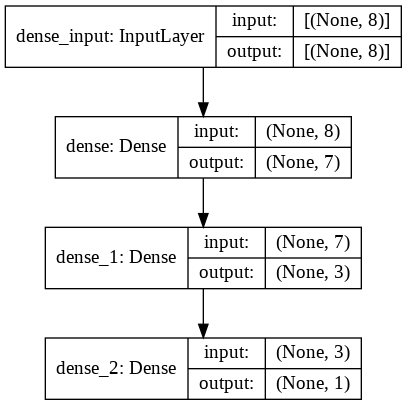

In [33]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 
#model structure
K.clear_session() #layer label starts zero with clear session!
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    